In [1]:
import numpy as np
import pandas as pd

from utils import *
from constants import *
from models import *

## Display Results

## Display Results

In [2]:
results = pd.read_csv('results_paper.csv')

# Print results
for idx, row in results.iterrows():
    print("Model:", row['Model Name'])
    for metric, value in row.items():
        if metric != 'Model Name':
            print(f"{metric:50} {value if isinstance(value, str) else round(value, 2)}")
    print("\n")

Model: BNN
Train RMSE                                         37.45
Train MAE                                          20.6
Test RMSE                                          40.28
Test MAE                                           22.54
Test % within 99.00% CI                            97.18
Test % within 95.00% CI                            91.79


Model: PMLP A1
Train RMSE                                         24.86
Train MAE                                          13.47
Test RMSE                                          28.97
Test MAE                                           15.94
Test % within 99.00% CI                            97.52
Test % within 95.00% CI                            92.21


Model: LPMLP A1
Train RMSE                                         23.91
Train MAE                                          12.9
Test RMSE                                          27.38
Test MAE                                           14.81
Test % within 99.00% CI                     

In [3]:
# Format results to be added to a latex table.

results = pd.read_csv('results_paper.csv')

metrics = results.columns[1:]

for idx, row in results.iterrows():
    formatted_line = ""
    for i, metric in enumerate(metrics):
        value = row[metric]
        # Try converting string values to floats
        try:
            value = float(value)
        except ValueError:
            pass 
        # Format the value to two decimal places
        formatted_value = "{:.2f}".format(value) if isinstance(value, float) else value
        if i == len(metrics) - 1:
            formatted_value += "\%" 
        
        formatted_line += f" & {formatted_value}"
        if i == 0:
            formatted_line = str(row['Model Name']) + " " + formatted_value
    print(formatted_line + " \\\\")
    print("\n")

BNN 37.45 & 20.60 & 40.28 & 22.54 & 97.18 & 91.79\% \\


PMLP A1 24.86 & 13.47 & 28.97 & 15.94 & 97.52 & 92.21\% \\


LPMLP A1 23.91 & 12.90 & 27.38 & 14.81 & 98.40 & 94.56\% \\


PMLP A2 25.93 & 14.28 & 28.84 & 15.94 & 97.48 & 92.57\% \\


LPMLP A2 23.01 & 12.42 & 27.52 & 14.91 & 97.89 & 93.09\% \\


GP (RBF, sparse) 47.37 & 32.17 & 49.57 & 33.87 & 93.20 & 88.06\% \\




## Additional Plots

In [4]:
df_train = pd.read_pickle(open(DATA_PATH + '/cleaned_temp/train.pkl','rb'))
df_test = pd.read_pickle(open(DATA_PATH + '/cleaned_temp/test.pkl','rb'))

In [5]:
print("Full Training Set Size: ", df_train.shape[0])
print("Full Testing Set Size: ", df_test.shape[0])

df_train_single = df_train[df_train['turbine'] == TURBINE_ID]
df_test_single = df_test[df_test['turbine'] == TURBINE_ID]
df_train_single.reset_index(drop=True, inplace=True)
print("Turbine#{TURBINE_ID} Training Set Size: ", df_train.shape[0])
print("Turbine#{TURBINE_ID} Testing Set Size: ", df_test.shape[0])
df = pd.concat([df_train_single, df_test_single])

Full Training Set Size:  677572
Full Testing Set Size:  169396
Turbine#{TURBINE_ID} Training Set Size:  677572
Turbine#{TURBINE_ID} Testing Set Size:  169396


In [6]:
X_train, X_test, \
    y_train, y_test, \
    scaler = create_design_matrix(df_train_single, df_test_single, FEATURES, OUTPUT_FEATURE)

In [7]:
df_preds = pd.read_csv('preds_paper.csv')

bnn_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'BNN', 'y_test_pred'].tolist())
bnn_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'BNN', 'y_test_stddevs'].tolist())
mlp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'PMLP A1', 'y_test_pred'].tolist())
mlp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'PMLP A1', 'y_test_stddevs'].tolist())
gp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_pred'].tolist())
gp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_stddevs'].tolist())
mlp_ft_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'LPMLP A1', 'y_test_pred'].tolist())
mlp_ft_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'LPMLP A1', 'y_test_stddevs'].tolist())
lmlp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'PMLP A2', 'y_test_pred'].tolist())
lmlp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'PMLP A2', 'y_test_stddevs'].tolist())
lmlp_ft_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'LPMLP A2', 'y_test_pred'].tolist())
lmlp_ft_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'LPMLP A2', 'y_test_stddevs'].tolist())

y_test_pred_list = [gp_pred,
                    bnn_pred,
                    mlp_pred,
                    mlp_ft_pred,
                    lmlp_pred,
                    lmlp_ft_pred]

y_test_std_list = [gp_stddevs,
                    bnn_stddevs,
                    mlp_stddevs,
                    mlp_ft_stddevs,
                    lmlp_stddevs,
                    lmlp_ft_stddevs]

y_test_list = [y_test,
                y_test,
                y_test,
                y_test,
                y_test,
                y_test]

titles = ["Sparse GP",
            "BNN",
            "PMLP with architecture A1",
            "LPMLP with architecture A1",
            "PMLP with architecture A2",
            "LPMLP with architecture A2 "]

Sparse GP, MCE: 6.943264145752451
BNN, MCE: 3.633723596123872
PMLP with architecture A1, MCE: 3.748968300064206
LPMLP with architecture A1, MCE: 0.935102252926967
PMLP with architecture A2, MCE: 2.542414330694214
LPMLP with architecture A2 , MCE: 2.1786445755510044


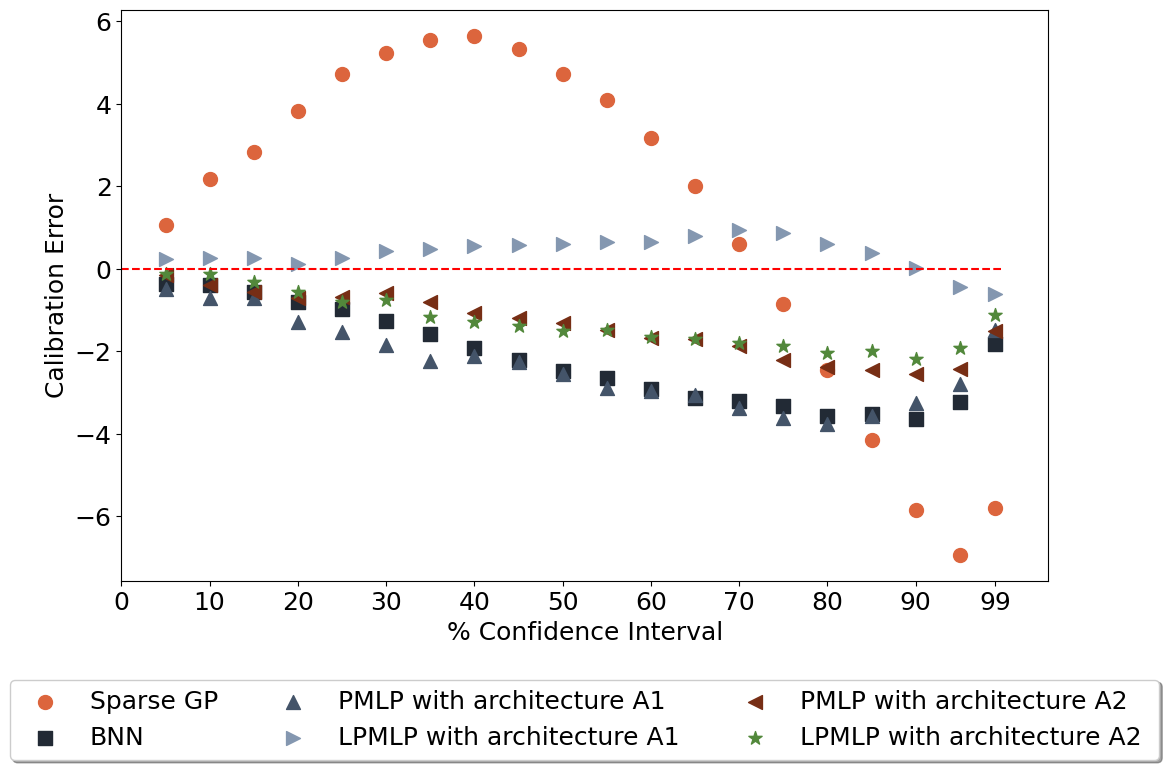

In [23]:
plot_calibration_errors(y_test_pred_list, y_test_std_list, y_test_list, bins=20, with_legend=False, titles=titles) 

## Interactive QQ plot

In [9]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/FYP/UK Wind Turbines"

df = pd.read_pickle(open(DATA_PATH + '/cleaned/full.pkl','rb'))

In [10]:
df = df[df['turbine'] == TURBINE_ID]
df = df.dropna(subset=FEATURES + [OUTPUT_FEATURE] + [DATETIME_COL])
df.reset_index(drop=True, inplace=True)


In [11]:
X_live, y_live = get_live_data(df, start_index=-144)

In [12]:
model = create_model_mlp_gaussian_large(X_live, 42)
model.summary()

model.load_weights('saved_models_paper/mlp_large_finetuned.keras')
evaluation = model.evaluate(X_live, y_live)
print("Evaluation Loss:", evaluation)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense (Dense)               (None, 300)               12300     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                            

In [13]:
y_live_pred = np.array(model(X_live).mean()).ravel()
y_live_stddevs = np.array(model(X_live).stddev()).ravel()

evaluate_and_save_metrics(None,
    y_live, y_live, y_live_pred, y_live_pred,
    y_live_stddevs, y_live_stddevs, 0.99)

Train RMSE: 47.349
Test RMSE: 47.349
Train MAE: 32.758
Test MAE: 32.758
Percentage of Test Data Points within 99.00% CI: 58.26%
Percentage of Test Data Points within 99.00% CI: 58.26%
Percentage of Test Data Points within 95.00% CI: 43.92%
Percentage of Test Data Points within 95.00% CI: 43.92%


In [14]:
t = 2850
dates = df.loc[t:t+143, DATETIME_COL]
X_live, y_live = get_live_data(df, t, t+143)
normalized_residuals = calculate_normalized_residuals(model, X_live, y_live)

In [15]:
# qq_plot(normalized_residuals, 0.99)
interactive_qq_plot(df, model)

interactive(children=(IntText(value=230, description='Start Index:'), IntText(value=374, description='End Inde…

In [16]:
def cusum_test_plot(residuals, datetime_values, target=0, k=0.5, h=5, save_path=None):
    """Perform a two-sided CUSUM test on residuals and plot.

    Args:
       residuals (list or array-like): List of normalized residuals.
        datetime_values (list or array-like): List of datetime values corresponding to the residuals.
        target (float): Target mean for normalized residuals.
        k (float): Reference value (allowable slack before signal), typically a small positive number.
        h (float): Decision interval (control limit).
    """
    datetime_values.reset_index(drop=True, inplace=True)  # Reset index

    colors = ['#445469', '#772E15']
    S_pos = [0]
    S_neg = [0]

    # Two-sided CUSUM test
    for i in range(1, len(residuals)):
        S_pos.append(max(0, S_pos[i-1] + residuals[i] - target - k))
        S_neg.append(min(0, S_neg[i-1] + residuals[i] - target + k))
        
    # Find the index of the first occurrence where the control limit is surpassed
    control_index_pos = next((i for i, value in enumerate(S_pos) if value > h), None)
    control_index_neg = next((i for i, value in enumerate(S_neg) if value < -h), None)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(datetime_values, S_pos, linestyle='--', label='S' + '\u2095', color=colors[0], linewidth=2.5)
    plt.plot(datetime_values, S_neg, linestyle='-.', label='S' + '\u2097', color=colors[1], linewidth=2.5)
    plt.axhline(y=h, color=colors[0], label='-I', linewidth=2.5)
    plt.axhline(y=-h, color=colors[1], label='I', linewidth=2.5)
    plt.text(datetime_values.iloc[-1], h + 0.3, f'I = {h}', 
             color=colors[0], ha='right', fontsize=12, va='bottom', weight='bold')
    plt.text(datetime_values.iloc[-1], -h - 0.3, f'-I = {-h}', 
             color=colors[1], ha='right', fontsize=12, va='top', weight='bold')
    plt.xlabel('Date & Time')
    plt.ylabel('Cumulative Sum')

    y_min = -10
    y_max = 10
    plt.ylim(-h * 1.5, h * 1.5)

    if min(S_neg) < y_min:
        plt.ylim(y_min * 1.1, y_max)
    if max(S_pos) > y_max:
        plt.ylim(y_min, y_max * 1.1)

    indices = np.linspace(0, len(datetime_values) - 1, 5, dtype=int)
    selected_dates = pd.to_datetime(datetime_values.iloc[indices])

    plt.xticks(selected_dates, [date.strftime('%Y-%m-%d\n%H:%M') for date in selected_dates], rotation=45, ha='right')

    if control_index_pos is not None:
        plt.scatter(datetime_values.iloc[control_index_pos], S_pos[control_index_pos], color='none', edgecolor='red', linewidths=2, s=200, zorder=5)
        plt.text(datetime_values.iloc[control_index_pos], S_pos[control_index_pos] + 0.75, 
                 datetime_values.iloc[control_index_pos].strftime('%Y-%m-%d\n%H:%M'), 
                 ha='right', fontsize=12, color='black', va='top', zorder=6,
                 bbox=dict(boxstyle="round", ec='black', fc='white', alpha=0.5))
    if control_index_neg is not None:
        plt.scatter(datetime_values.iloc[control_index_neg], S_neg[control_index_neg], color='none', edgecolor='red', linewidths=2, s=200, zorder=5)
        plt.text(datetime_values.iloc[control_index_neg], S_neg[control_index_neg] - 0.75, 
                 datetime_values.iloc[control_index_neg].strftime('%Y-%m-%d\n%H:%M'), 
                 ha='right', fontsize=12, color='black', va='top', zorder=6,
                 bbox=dict(boxstyle="round", ec='black', fc='white', alpha=0.5))
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()

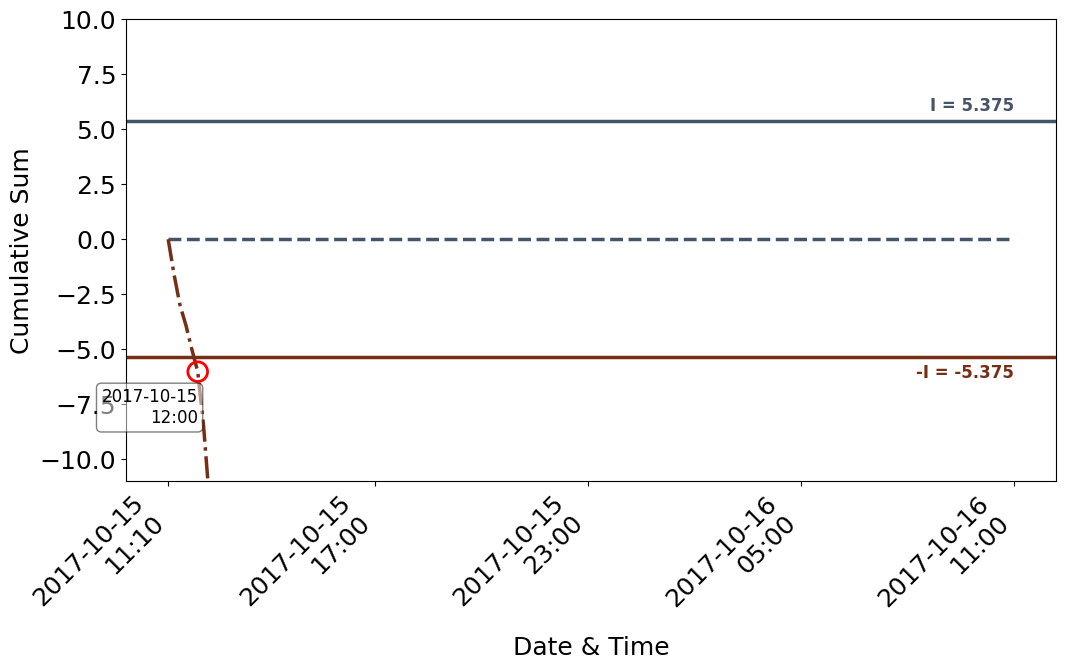

In [17]:
cusum_test_plot(normalized_residuals, pd.to_datetime(dates), h=5.375)

In [18]:
df = pd.read_pickle(DATA_PATH + '/unfiltered/full.pkl')
df = df[df['turbine'] == TURBINE_ID]

c:\Users\filip\OneDrive\Documenti\UCL\FYP\Wind Turbines\code submission - Copia\fyp\utils.py:580: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_path, format='pdf', bbox_inches='tight')
c:\Users\filip\OneDrive\Documenti\UCL\FYP\Wind Turbines\code submission - Copia\fyp\utils.py:580: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_path, format='pdf', bbox_inches='tight')
c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


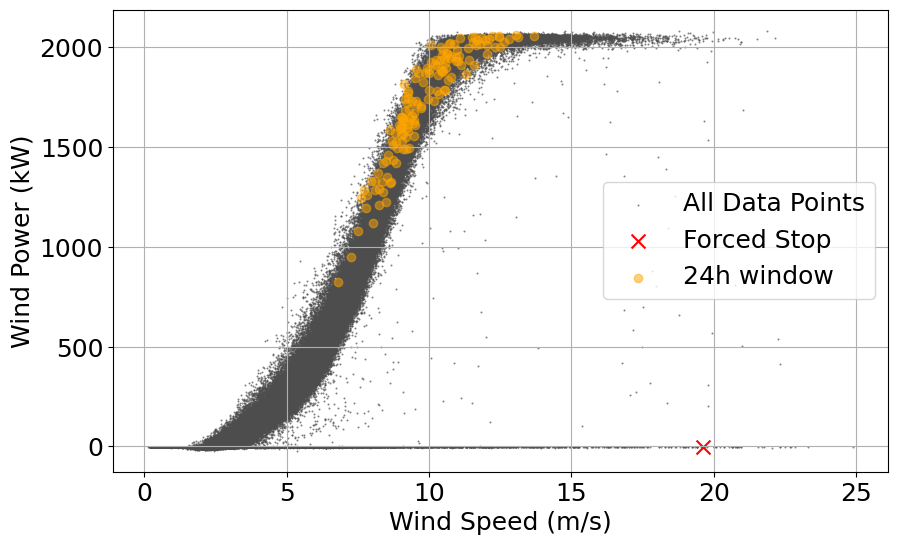

In [19]:
fault_date = pd.Timestamp('2018-01-18 04:22:23') # Where the fault is
reference_date = pd.Timestamp('2018-01-17 10:30:01') # Illustrative to show the fault is detected early
mask_fault = (pd.to_datetime(df[DATETIME_COL]) > fault_date) \
        & (pd.to_datetime(df[DATETIME_COL]) < fault_date + pd.Timedelta(minutes=10))

mask_period = (pd.to_datetime(df[DATETIME_COL]) > reference_date - pd.Timedelta(minutes=10*143)) \
        & (pd.to_datetime(df[DATETIME_COL]) < reference_date - pd.Timedelta(minutes=10))
unhealthy_indices = detect_visible_faults(df, mask_fault, mask_period, save_path="plots/fault.pdf")

In [20]:
df_unhealthy = df.loc[unhealthy_indices.index]
df_unhealthy.dropna(subset=FEATURES + [OUTPUT_FEATURE], inplace=True)
display(df_unhealthy)

,Date.time,Wind.dir.std,Power.me,Power.sd,Power.min,Power.max,Pot.Power.me,Wind.speed.me,Wind.speed.sd,Wind.speed.min,...,Tower.Acceleration.x,Tower.Acceleration.y,turbine,year,Wind.dir.sin.me,Wind.dir.cos.me,Wind.dir.sin.min,Wind.dir.cos.min,Wind.dir.sin.max,Wind.dir.cos.max
1262657,2018-01-16 10:50:00,8.139742,1909.519165,266.490570,1067.984253,2119.685547,1853.582153,10.285767,1.399522,7.726889,...,70.482315,52.208694,5,2018,-0.979859,-0.199693,-0.933833,-0.357708,-0.994958,0.100296
1262658,2018-01-16 11:00:00,8.600014,1531.671265,339.942139,906.857117,2068.765137,1251.293430,8.687610,1.190002,6.108610,...,84.512482,43.793907,5,2018,-0.964217,-0.265114,-0.829863,-0.557968,-0.999012,-0.044447
1262659,2018-01-16 11:10:00,14.056508,1493.141602,407.602753,848.232422,2088.196289,1460.726662,9.204111,1.512391,6.749016,...,80.764374,36.559395,5,2018,-0.958152,-0.286261,-0.805323,-0.592836,-0.958505,0.285077
1262660,2018-01-16 11:20:00,9.966332,1765.530762,373.574249,1006.307800,2103.306152,1865.873246,10.345723,1.634526,6.508446,...,77.111473,53.886345,5,2018,-0.968852,-0.247642,-0.871021,-0.491247,-0.999086,0.042744
1262661,2018-01-16 11:30:00,11.224511,1629.931152,376.086273,882.474609,2097.789307,1442.771912,9.161362,2.270015,5.262903,...,95.147873,50.728996,5,2018,-0.953213,-0.302299,-0.651646,-0.758523,-0.999544,-0.030201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262794,2018-01-17 09:40:00,11.558060,1887.560547,246.013077,1206.329468,2116.078857,1880.839605,10.418730,1.537820,6.493225,...,128.534912,56.967518,5,2018,-0.988972,-0.148100,-0.882444,-0.470417,-0.988216,0.153064
1262795,2018-01-17 09:50:00,9.495464,1966.007080,149.531677,1566.507324,2123.889893,1923.204179,10.625386,1.462721,8.072894,...,121.263382,90.984489,5,2018,-0.996850,-0.079316,-0.916745,-0.399472,-0.980701,0.195516
1262796,2018-01-17 10:00:00,9.557837,1973.789185,152.976486,1549.306152,2144.185303,1923.664589,10.627632,1.919650,6.680706,...,119.074821,67.491516,5,2018,-0.990913,-0.134508,-0.879109,-0.476621,-0.993622,0.112763
1262797,2018-01-17 10:10:00,8.873287,2000.796631,113.905174,1784.455811,2127.571289,2043.098030,12.309803,1.785712,8.483497,...,100.934349,91.240997,5,2018,-0.991496,-0.130139,-0.877440,-0.479687,-0.997273,0.073803


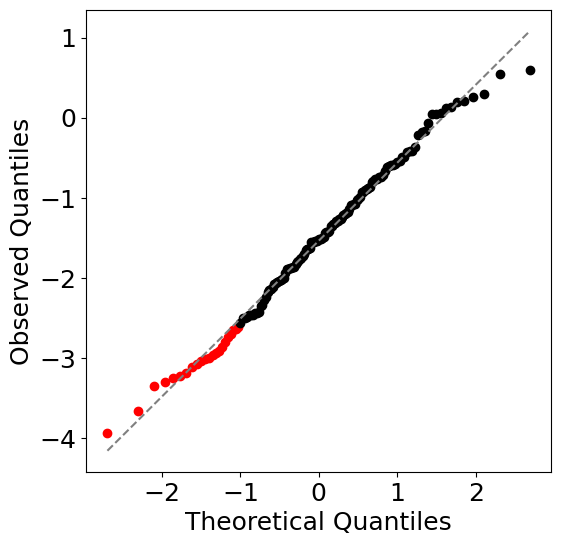

In [21]:
X_unhealthy, y_unhealthy = get_live_data(df_unhealthy, 0)
normalized_residuals = calculate_normalized_residuals(model, X_unhealthy, y_unhealthy)

qq_plot(normalized_residuals ,0.99)

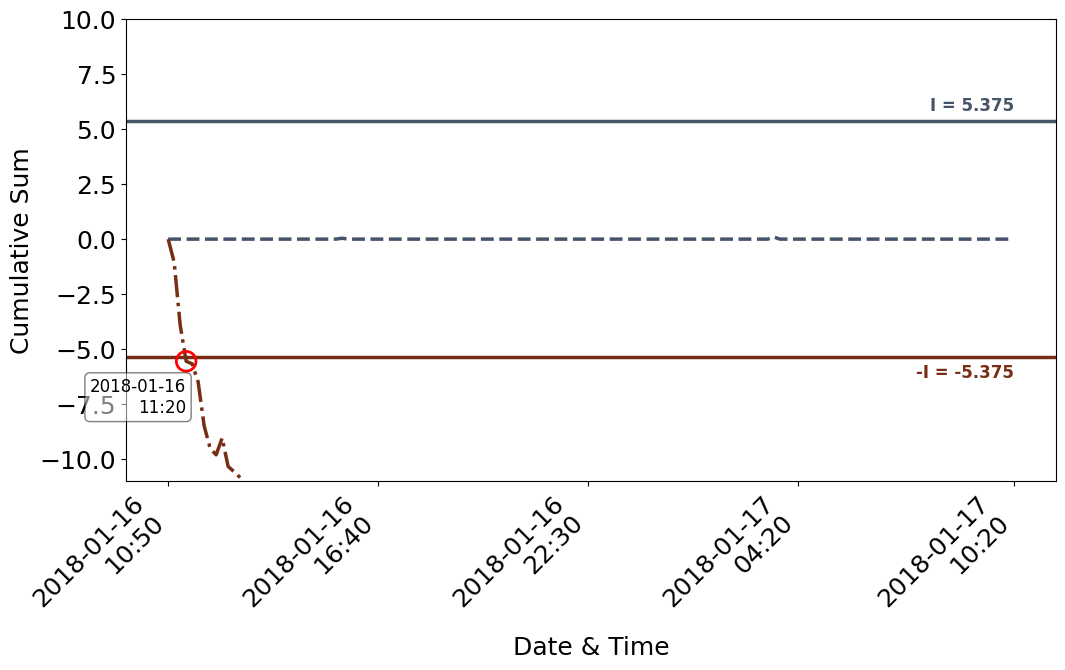

In [22]:
cusum_test_plot(normalized_residuals, pd.to_datetime(df_unhealthy[DATETIME_COL]), h=5.375)